In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv
/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
np.random.seed(42)


In [ ]:
train_data = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")
test_data = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")

In [ ]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nFirst few rows of training data:")
print(train_data.head())


Training data shape: (8000, 30)
Test data shape: (2845, 29)

First few rows of training data:
   Unnamed: 0  ID  class  20150720_N  20150602_N  20150517_N  20150501_N  \
0           0   1  water    637.5950     658.668   -1882.030    -1924.36   
1           1   2  water    634.2400     593.705   -1625.790    -1672.32   
2           3   4  water     58.0174   -1599.160         NaN    -1052.63   
3           4   5  water     72.5180         NaN     380.436    -1256.93   
4           7   8  water   1136.4400         NaN         NaN     1647.83   

   20150415_N  20150330_N  20150314_N  ...  20140610_N  20140525_N  \
0     997.904   -1739.990     630.087  ...         NaN   -1043.160   
1     914.198    -692.386     707.626  ...         NaN    -933.934   
2         NaN   -1564.630         NaN  ...    -1025.88     368.622   
3     515.805   -1413.180    -802.942  ...    -1813.95     155.624   
4    1935.800         NaN    2158.980  ...     1535.00    1959.430   

   20140509_N  20140423_N  2

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [ ]:
print("\nMissing values in training data:")
print(train_data.isnull().sum().sum())


Missing values in training data:
25040


In [ ]:
print("\nClass distribution:")
print(train_data['class'].value_counts())


Class distribution:
class
forest        6159
farm           841
impervious     669
grass          196
water          105
orchard         30
Name: count, dtype: int64


In [ ]:
def preprocess_data(df, is_train=True):

    processed_df = df.copy()


    if is_train:
        X = processed_df.drop(['ID', 'class'], axis=1)
        y = processed_df['class']
    else:
        X = processed_df.drop(['ID'], axis=1)
        y = None


    date_columns = [col for col in X.columns if '_N' in col]
    dates = pd.to_datetime([col.split('_')[0] for col in date_columns], format='%Y%m%d')


    ndvi_df = X[date_columns].copy()
    ndvi_df.columns = dates


    features = {
        'mean': ndvi_df.mean(axis=1),
        'median': ndvi_df.median(axis=1),
        'std': ndvi_df.std(axis=1),
        'min': ndvi_df.min(axis=1),
        'max': ndvi_df.max(axis=1),
        'range': ndvi_df.max(axis=1) - ndvi_df.min(axis=1),
        'q25': ndvi_df.quantile(0.25, axis=1),
        'q75': ndvi_df.quantile(0.75, axis=1),
    }


    winter_cols = [col for col in ndvi_df.columns if col.month in [12, 1, 2]]
    spring_cols = [col for col in ndvi_df.columns if col.month in [3, 4, 5]]
    summer_cols = [col for col in ndvi_df.columns if col.month in [6, 7, 8]]
    fall_cols = [col for col in ndvi_df.columns if col.month in [9, 10, 11]]

    if winter_cols:
        features['winter_mean'] = ndvi_df[winter_cols].mean(axis=1)
        features['winter_std'] = ndvi_df[winter_cols].std(axis=1)
    if spring_cols:
        features['spring_mean'] = ndvi_df[spring_cols].mean(axis=1)
        features['spring_std'] = ndvi_df[spring_cols].std(axis=1)
    if summer_cols:
        features['summer_mean'] = ndvi_df[summer_cols].mean(axis=1)
        features['summer_std'] = ndvi_df[summer_cols].std(axis=1)
    if fall_cols:
        features['fall_mean'] = ndvi_df[fall_cols].mean(axis=1)
        features['fall_std'] = ndvi_df[fall_cols].std(axis=1)


    time_values = np.array([(d - ndvi_df.columns[0]).days for d in ndvi_df.columns])
    slopes = []
    for _, row in ndvi_df.iterrows():
        valid_idx = ~row.isna()
        if sum(valid_idx) > 1:
            slope = np.polyfit(time_values[valid_idx], row[valid_idx], 1)[0]
        else:
            slope = np.nan
        slopes.append(slope)
    features['slope'] = slopes

    features['missing_count'] = ndvi_df.isnull().sum(axis=1)


    feature_df = pd.DataFrame(features)


    imputer = SimpleImputer(strategy='median')
    feature_df_imputed = pd.DataFrame(imputer.fit_transform(feature_df),
                                     columns=feature_df.columns)

    if is_train:
        return feature_df_imputed, y
    else:
        return feature_df_imputed

In [ ]:
# Preprocess training and test data
X_train, y_train = preprocess_data(train_data, is_train=True)
X_test = preprocess_data(test_data, is_train=False)

# Check the processed data
print("\nProcessed training features shape:", X_train.shape)
print("Processed test features shape:", X_test.shape)


Processed training features shape: (8000, 18)
Processed test features shape: (2845, 18)


In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # To handle class imbalance
    )
)


In [ ]:
model.fit(X_train_split, y_train_split)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    multi_class='multinomial',
                                    random_state=42))])

In [ ]:
val_preds = model.predict(X_val_split)
val_accuracy = accuracy_score(y_val_split, val_preds)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.6963



Submission file saved as 'submission.csv'


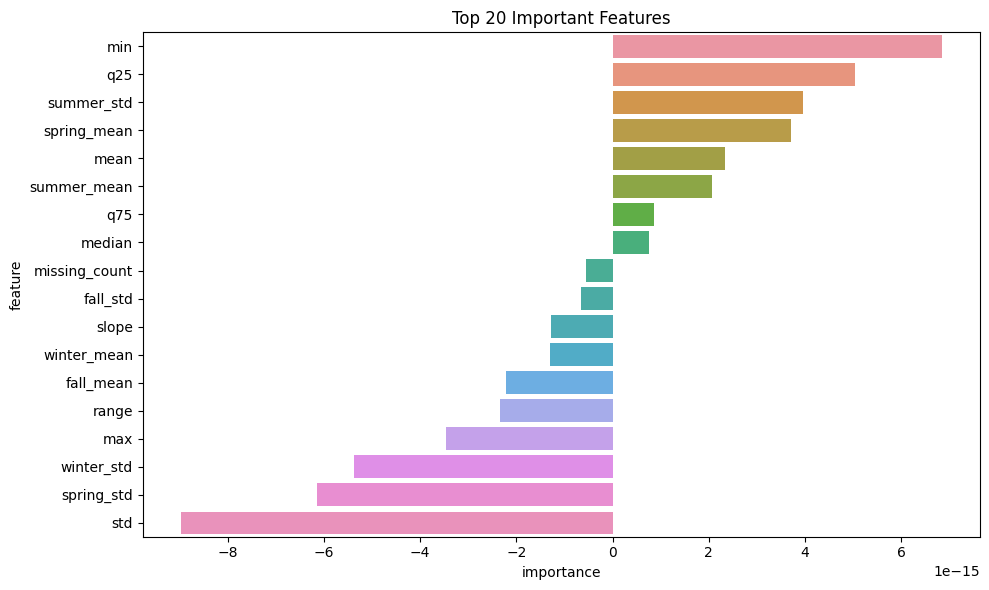

In [ ]:
final_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )
)

final_model.fit(X_train, y_train)


test_preds = final_model.predict(X_test)

submission = pd.DataFrame({
    'ID': test_data['ID'],
    'class': test_preds
})


submission.to_csv('submission.csv', index=False)
print("\nSubmission file saved as 'submission.csv'")


if hasattr(final_model.named_steps['logisticregression'], 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': final_model.named_steps['logisticregression'].coef_.mean(axis=0)
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Important Features')
    plt.tight_layout()
    plt.show()